In [64]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
import global_values
from groups import *
from merge_groups_best_candidate import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_values.MODEL = SiameseCNN()
global_values.MODEL.load_state_dict(torch.load("siamese_weights.pth", map_location=device))
global_values.MODEL.to(device)
global_values.MODEL.eval()
global_values.DEVICE = device
NN_SCORING = True



In [65]:
image_path = "disney_puzzle/aladin.jpg" 
output_folder = "fragments"

global_values.COL_NR = 4
global_values.ROW_NR = 4
solution_path = f"solution/valid_comparisons_{global_values.COL_NR}_{global_values.ROW_NR}_nn_pasting.txt"

fragments, tile_h, tile_w = divide_image(image_path, output_folder,solution_path, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)

fragment_rotation_dictionary = create_fragment_rotation_dictionary(fragments)


sides_comparisons = create_sides_comparisons(fragments,fragment_rotation_dictionary)



sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1, fragment_rotation_dictionary)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp



Creating rotation dictionary for all fragments


16it [00:00, 8997.03it/s]
100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


In [66]:
global_values.IMAGE_TH = 0.0007
global_values.GROUP_TH = 0.0002

In [67]:
for s in sorted_sides_comparisons[:100]:
    print(s)

Sides Comp: Score=3.898137583746575e-05 Fragment_idx1=1, Side_idx1=0; fragment_idx2=5, side_idx2=2
Sides Comp: Score=0.0003158272011205554 Fragment_idx1=0, Side_idx1=0; fragment_idx2=1, side_idx2=1
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=1, Side_idx1=3; fragment_idx2=2, side_idx2=1
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=2, Side_idx1=0; fragment_idx2=6, side_idx2=0
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=4, Side_idx1=2; fragment_idx2=5, side_idx2=1
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=5, Side_idx1=0; fragment_idx2=8, side_idx2=1
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=5, Side_idx1=3; fragment_idx2=6, side_idx2=3
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=6, Side_idx1=1; fragment_idx2=7, side_idx2=3
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=8, Side_idx1=3; fragment_idx2=12, side_idx2=2
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=10, Side_idx1=0; fragment_idx2=11, side_idx2=1
Sides C

In [68]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [69]:
for comp in sorted_sides_comparisons:
    if comp.score <= global_values.IMAGE_TH:

        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]

        if anchor_group_idx != pasted_group_idx:

            shifted_anchor_group, shifted_pasted_group, pasted_group_additional_rotation = simulate_merge_positions(fragments, comp, groups[anchor_group_idx], groups[pasted_group_idx])

            if does_merge_fit_within_bounds(shifted_anchor_group):
                if check_groups_shapes_for_merging(shifted_anchor_group, shifted_pasted_group):
                    # print(f"{comp}")

                    if check_all_group_matchings_scores(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group):    
                        # score = calculate_all_group_matchings_scores(shifted_anchor_group, shifted_pasted_group)
                        # anchor_img = shifted_anchor_group.show_group(fragments,0)
                        # pasted_img = shifted_pasted_group.show_group(fragments,pasted_group_additional_rotation)
                        # plt.imshow(anchor_img)
                        # plt.show()
                        # plt.imshow(pasted_img)
                        # plt.show()
                        # print("-------------------------------------------")
                        groups[anchor_group_idx] = merge_groups(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group, fragment_idx_to_group_idx)
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
                        print(comp)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 1)

# for g in groups:
#     print(g.fragment_positions)


Merged group 5 and 1 with total score: 3.898137583746575e-05 using: Sides Comp: Score=0.0008300948538817465 Fragment_idx1=5, Side_idx1=2; fragment_idx2=1, side_idx2=0


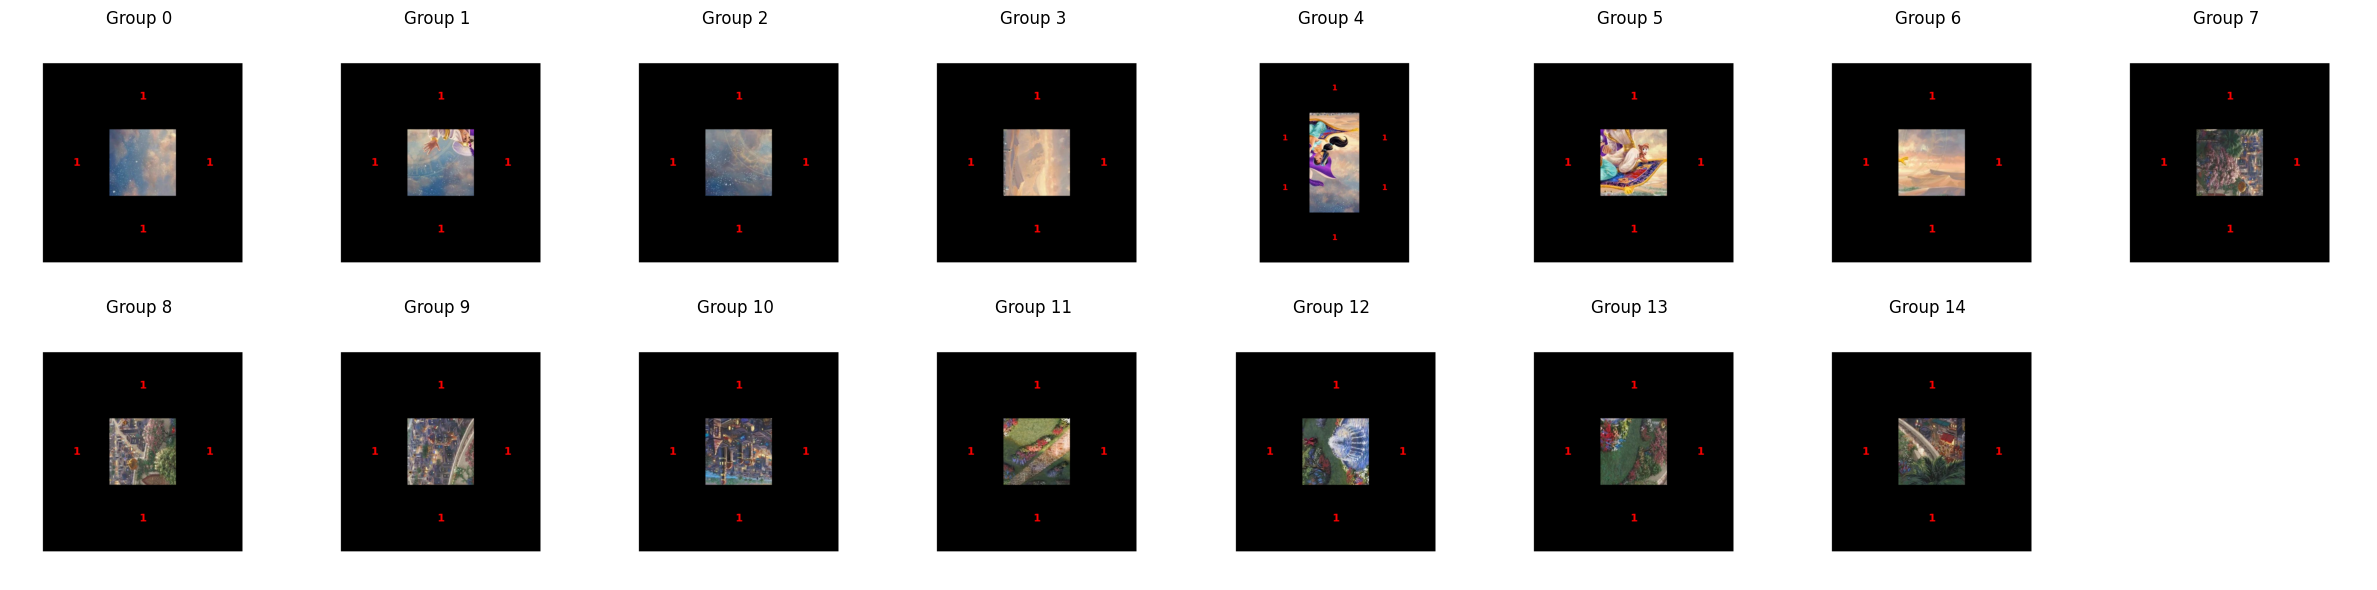

Merged group 4 and 0 with total score: 0.0003158272011205554 using: Sides Comp: Score=0.00045700959162786603 Fragment_idx1=1, Side_idx1=1; fragment_idx2=0, side_idx2=0


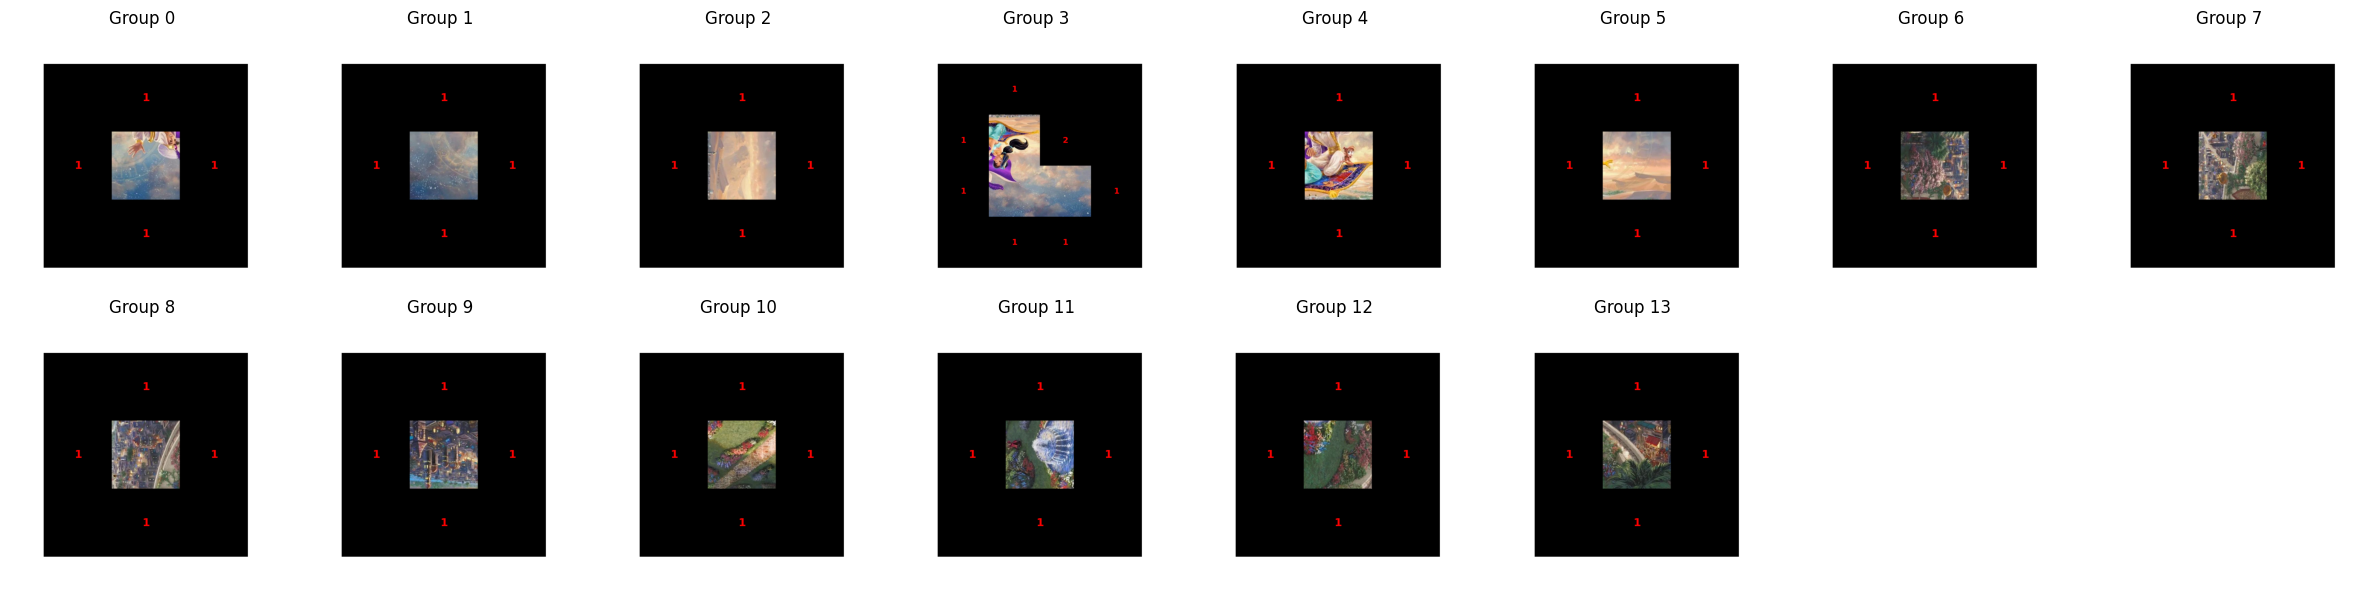

Merged group 3 and 2 with total score: 0.0025821669260039926 using: Sides Comp: Score=0.0007592652691528201 Fragment_idx1=0, Side_idx1=1; fragment_idx2=4, side_idx2=1


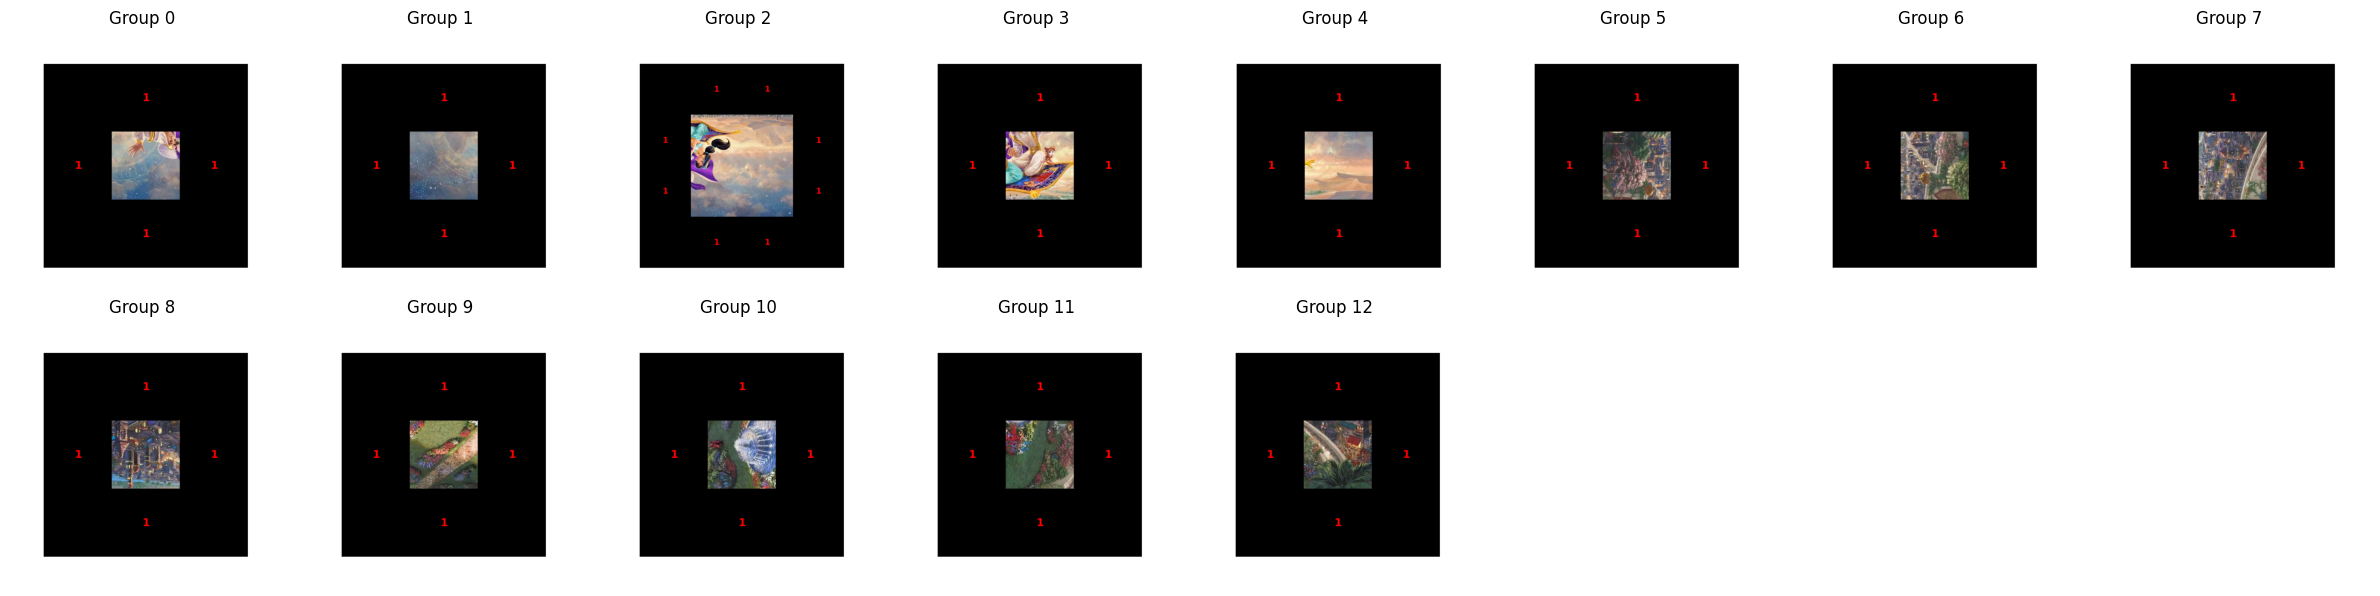

Merged group 0 and 3 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.0006262317765504122 Fragment_idx1=2, Side_idx1=0; fragment_idx2=6, side_idx2=0


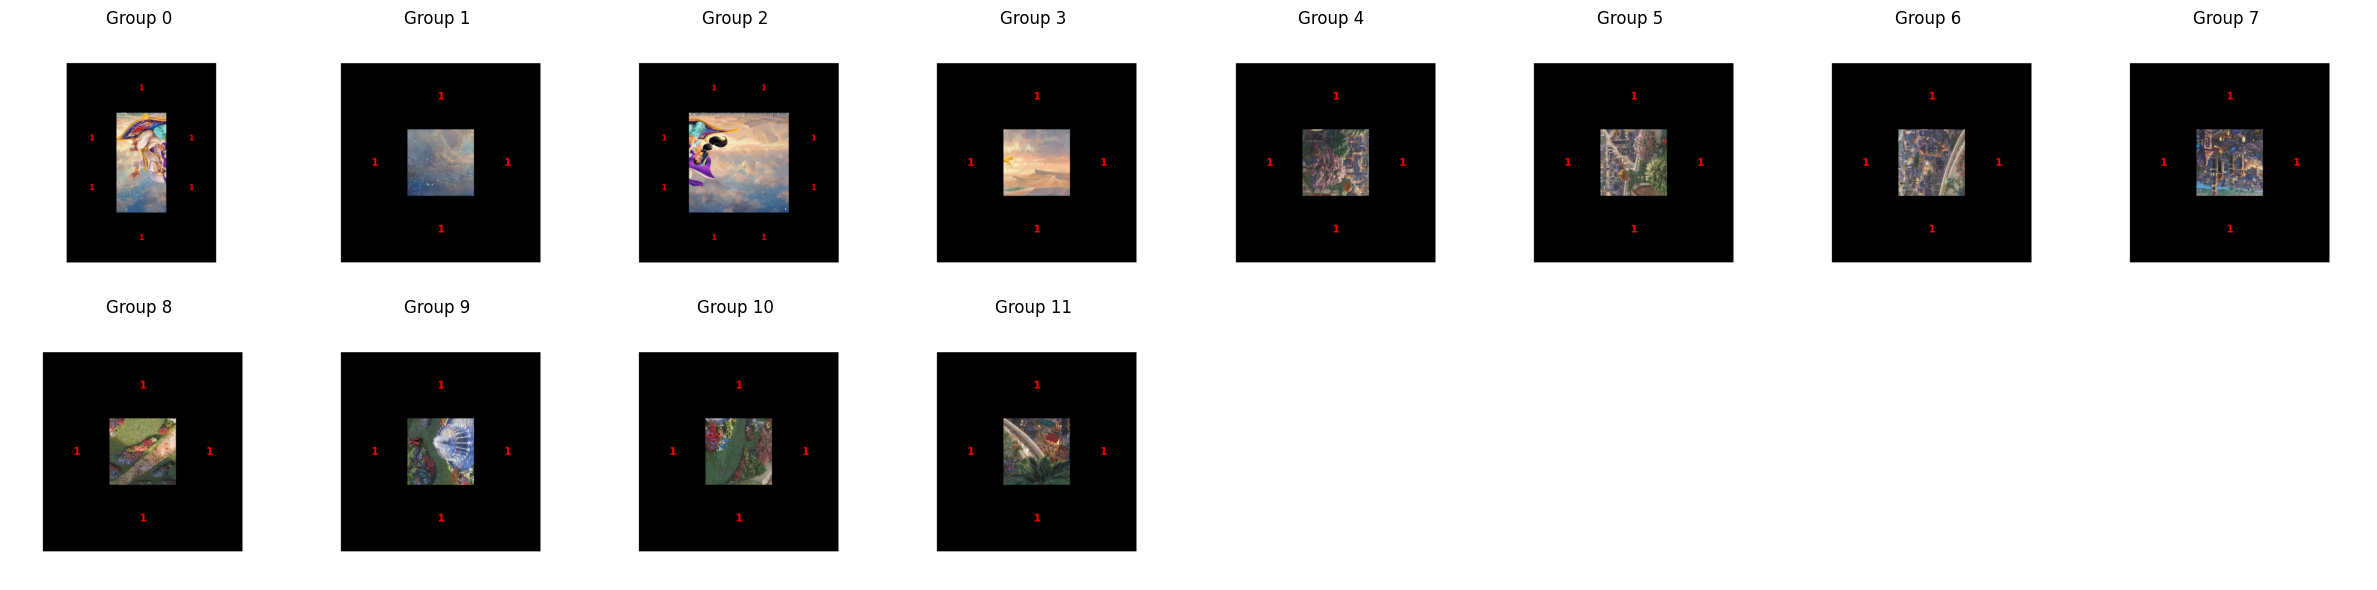

Merged group 0 and 3 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.0006262317765504122 Fragment_idx1=6, Side_idx1=1; fragment_idx2=7, side_idx2=3


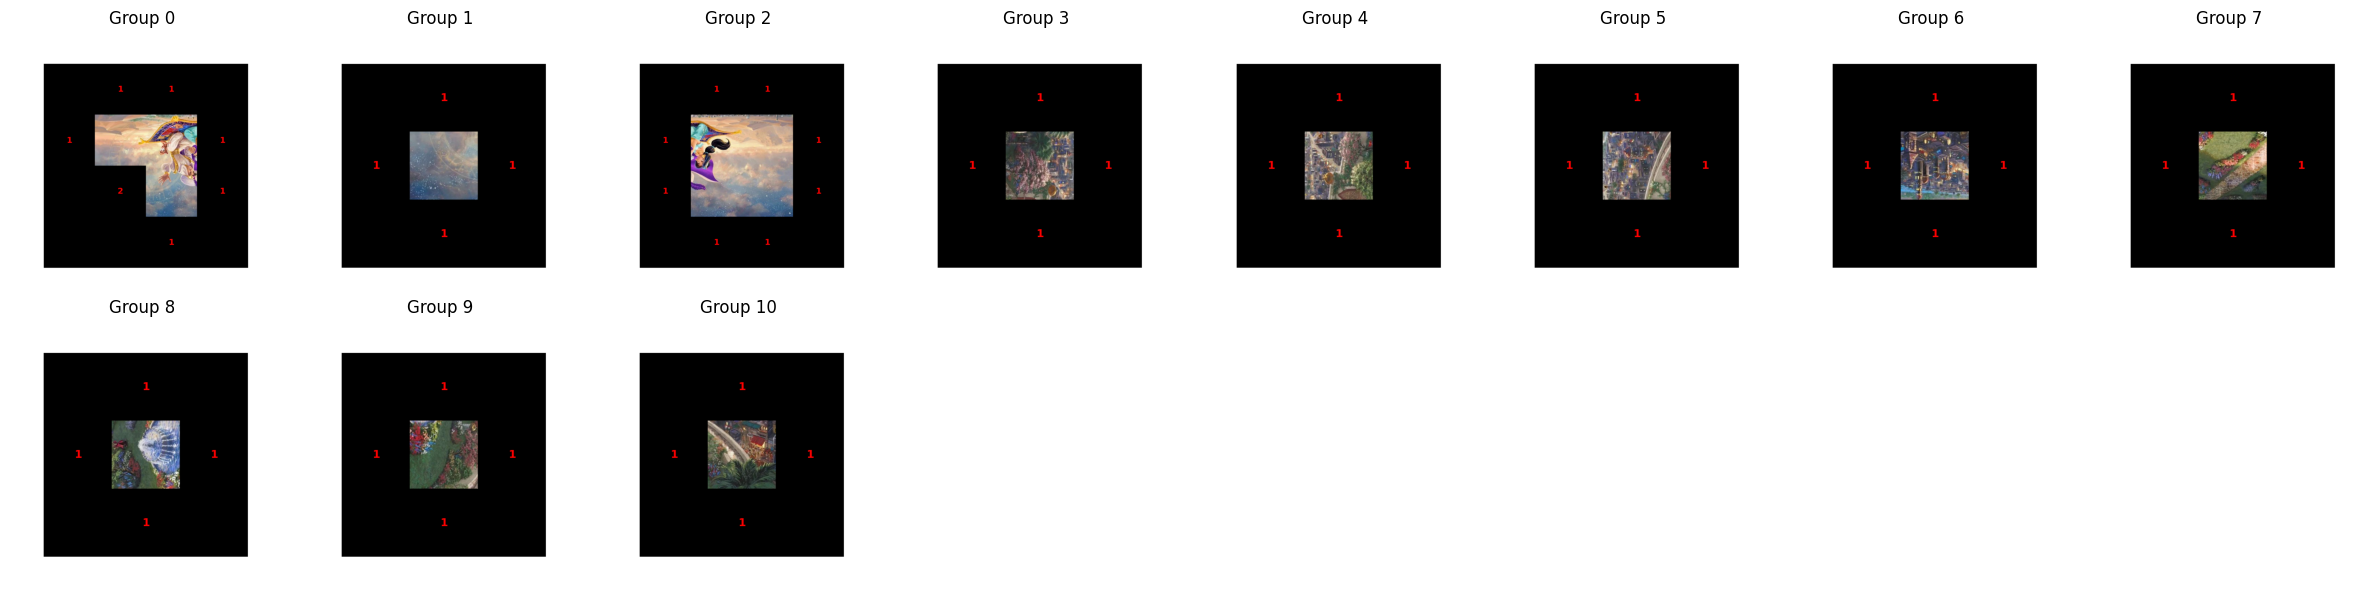

Merged group 0 and 1 with total score: 0.001332414394710213 using: Sides Comp: Score=0.0006647196714766324 Fragment_idx1=7, Side_idx1=0; fragment_idx2=3, side_idx2=0


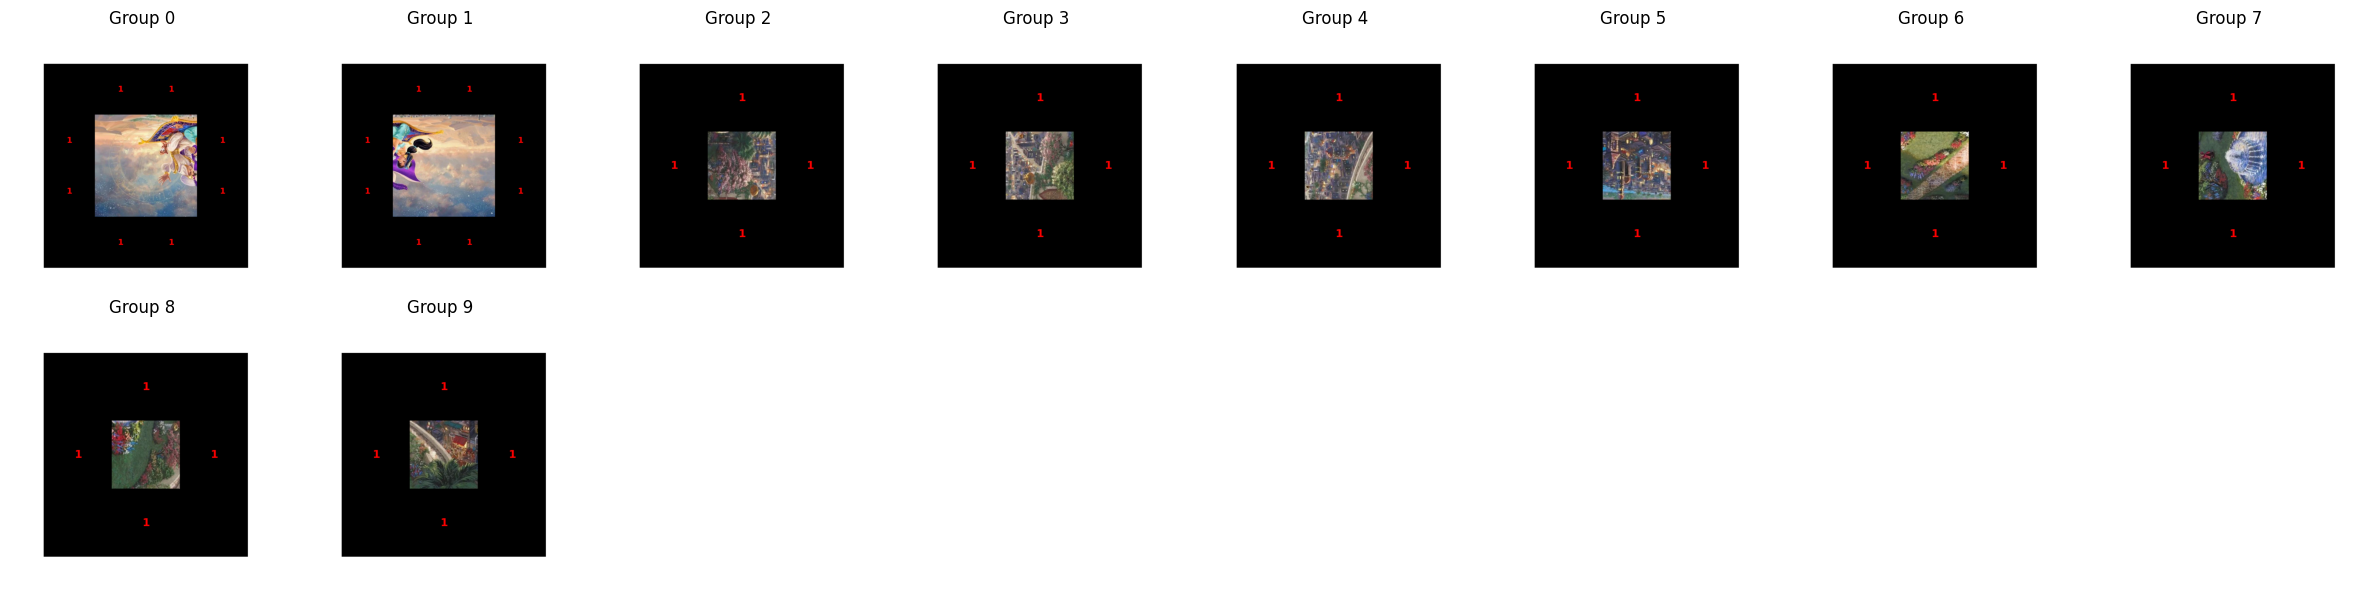

Merged group 0 and 1 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.0006262317765504122 Fragment_idx1=6, Side_idx1=3; fragment_idx2=5, side_idx2=3


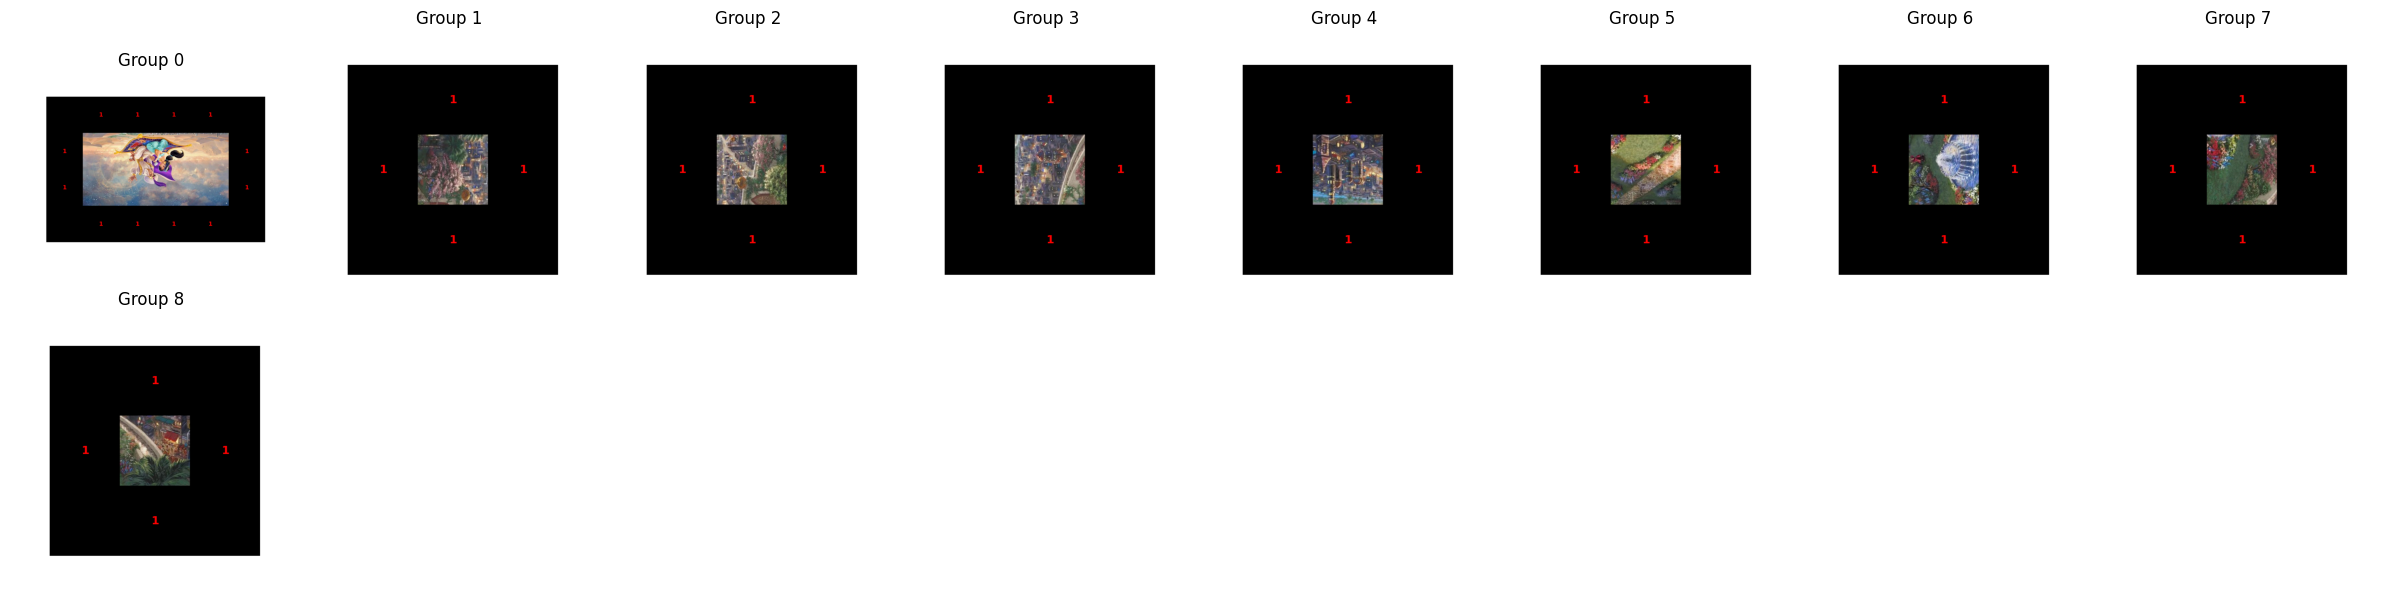

Merged group 1 and 0 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.028744477778673172 Fragment_idx1=8, Side_idx1=1; fragment_idx2=5, side_idx2=0


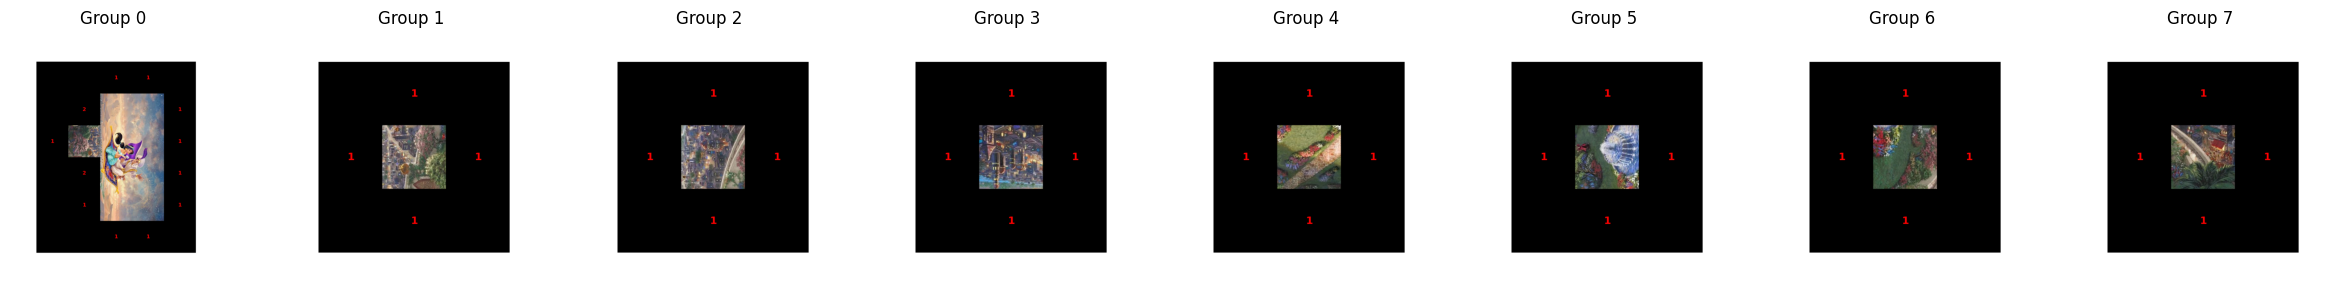

Merged group 0 and 3 with total score: 0.41159119829535484 using: Sides Comp: Score=0.10360603034496307 Fragment_idx1=8, Side_idx1=2; fragment_idx2=11, side_idx2=1


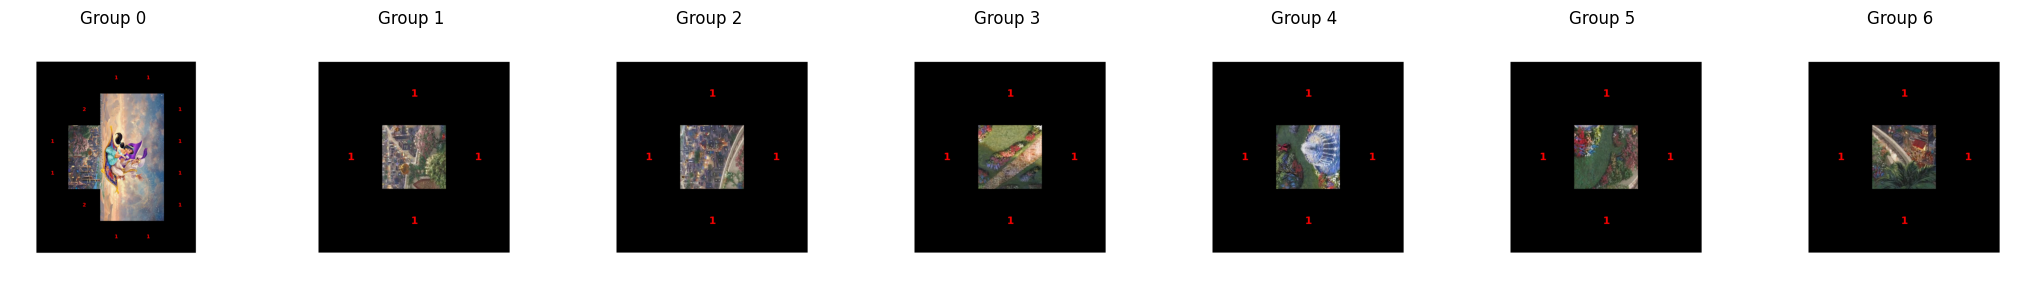

Merged group 0 and 3 with total score: 0.5468964204192162 using: Sides Comp: Score=0.9999983310699463 Fragment_idx1=4, Side_idx1=3; fragment_idx2=12, side_idx2=1


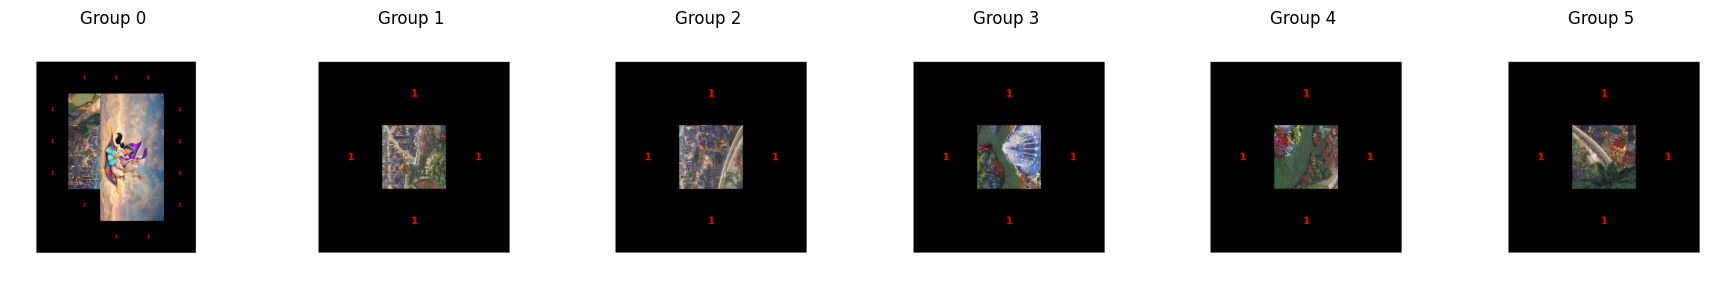

Merged group 0 and 1 with total score: 0.9501025378704071 using: Sides Comp: Score=1.0 Fragment_idx1=11, Side_idx1=3; fragment_idx2=9, side_idx2=2


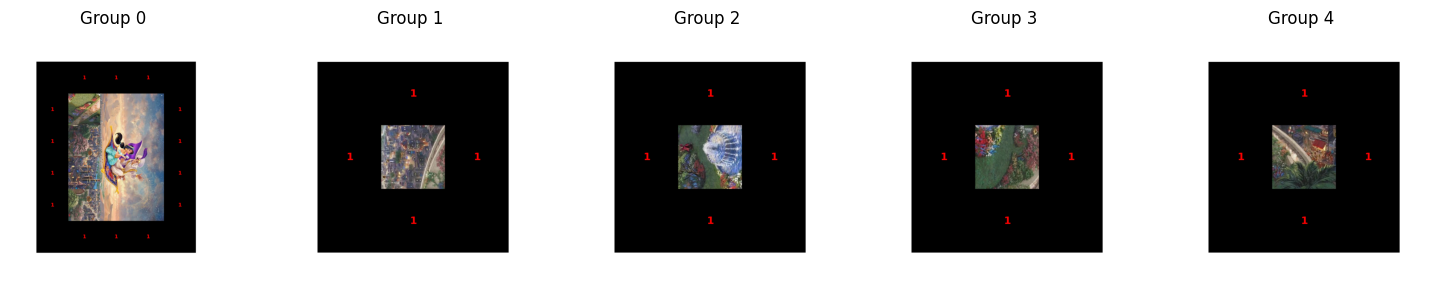

Merged group 1 and 3 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.0006262317765504122 Fragment_idx1=10, Side_idx1=1; fragment_idx2=14, side_idx2=1


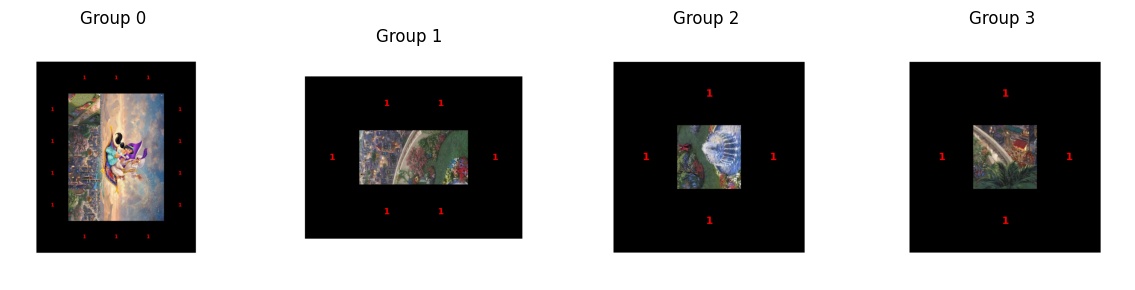

Merged group 3 and 1 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.005224086809903383 Fragment_idx1=15, Side_idx1=3; fragment_idx2=14, side_idx2=2


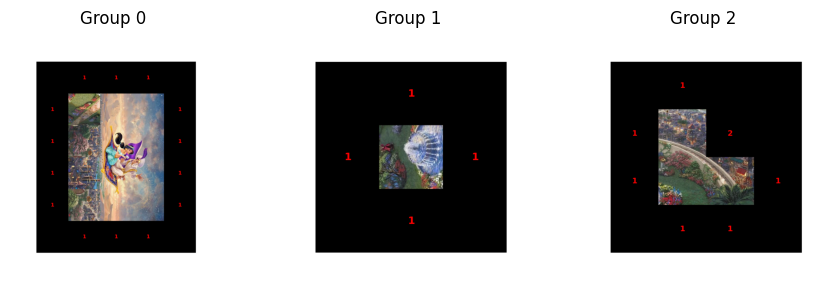

Merged group 2 and 1 with total score: 0.9999850392341614 using: Sides Comp: Score=1.0 Fragment_idx1=15, Side_idx1=0; fragment_idx2=13, side_idx2=1


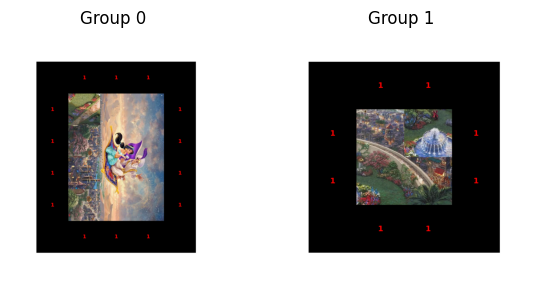

No valid merge candidates found.


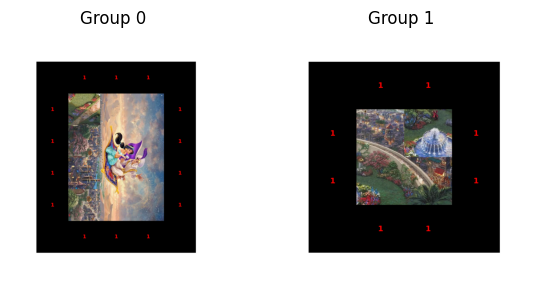

In [70]:
groups, fragments, fragment_idx_to_group_idx = solve_groups_safe(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)



In [71]:
gt_comparisons = read_valid_comparisons(solution_path)



comparisons = []

for g in groups:
    n = len(g.grid)
    m = len(g.grid[0])

    for i in range(n):
        for j in range(m):
            fr1_idx = g.grid[i][j]
            if fr1_idx is not None:
                if j + 1 < m:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 1)
                    fr2_idx = g.grid[i][j + 1]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation,3)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

                if i + 1 < n:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 2)
                    fr2_idx = g.grid[i + 1][j]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation, 0)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

correct = 0
nr_of_comp = int((2 * 4 + 3 * ((global_values.COL_NR - 2) * 2 + (global_values.ROW_NR - 2)* 2) + 4 * ((global_values.COL_NR -2) * (global_values.COL_NR-2)))/2)
for s_comp in comparisons:
    for gt_comp in gt_comparisons:
        if s_comp == gt_comp:
            correct+=1
        if s_comp[0] == gt_comp[1] and s_comp[1] == gt_comp[0] and s_comp[2] == gt_comp[3] and s_comp[3] == gt_comp[2]:
            correct+=1

accuracy = (correct/nr_of_comp) * 100
print(f"Accuracy of algorithm: {accuracy}%")

Accuracy of algorithm: 50.0%


In [72]:
# introducere problema imagini input output

# care e algolritmul (greedy)
# functia de potrivire
# siameza

# cum merge pe low level, simaza pe diferiti nr pixeli
# timp

# 9 iunie licenta
